# Neonatal Journal Club

Anoop Ramana 
24th Jan 2025

A breakdown of how to set up an ML pipeline inspired by the study’s methodology

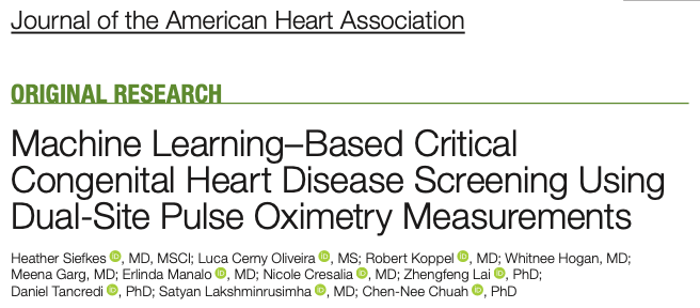

### Steps to Set Up the ML Pipeline

In [ ]:
! pip install numpy pandas scikit-learn matplotlib seaborn

### 1. Data Loading

In [ ]:
import pandas as pd
import numpy as np

# Simulate data
np.random.seed(42)
data = pd.DataFrame({
    'SpO2_preductal': np.random.uniform(90, 100, 500),
    'SpO2_postductal': np.random.uniform(85, 100, 500),
    'Pulse_delay': np.random.uniform(0, 10, 500),
    #'Perfusion_index': np.random.uniform(0.2, 5, 500),
    'CCHD': np.random.choice([0, 1], size=500, p=[0.9, 0.1])  # 10% CCHD cases
})

data.head()

In [ ]:
import matplotlib.pyplot as plt

# Count occurrences of each diagnosis
cchd_counts = data['CCHD'].value_counts()

# Bar chart for CCHD vs Healthy
plt.bar(cchd_counts.index, cchd_counts.values, tick_label=['Healthy', 'CCHD'])
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.title('Distribution of CCHD and Healthy Cases')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Plot pairplot of features
pd.plotting.scatter_matrix(data.iloc[:, :-1], figsize=(12, 8), alpha=0.8, diagonal='hist')

# Add a title to the plot
plt.suptitle("Scatter matrix plot for pairs", fontsize=16)

# Display the plot
plt.show()

### 2. Preprocessing and artifact removal

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Remove noisy data based on thresholds
clean_data = data[
    (data['SpO2_preductal'] > 85) &
    (data['SpO2_postductal'] > 85) &
    (data['Pulse_delay'] < 8)
]

# Split the dataset
X = clean_data[['SpO2_preductal', 'SpO2_postductal', 'Pulse_delay']]
y = clean_data['CCHD']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. Feature Engineering

Extract mean, variance, and additional metrics:

In [31]:
def extract_features(df):
    feature_df = df.copy()
    feature_df['SpO2_diff'] = feature_df['SpO2_preductal'] - feature_df['SpO2_postductal']
    feature_df['Pulse_to_pre_ratio'] = feature_df['Pulse_delay'] / feature_df['SpO2_preductal']
    feature_df['Pulse_to_post_ratio'] = feature_df['Pulse_delay'] / feature_df['SpO2_postductal']
    return feature_df

X_train = extract_features(X_train)
X_test = extract_features(X_test)

### 4. ML Model Training

Using Random Forest as an example:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# Performance Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))
print(f"AUROC: {roc_auc_score(y_test, y_pred_prob):.2f}")

In [ ]:
print(y_train.value_counts())

In [ ]:
feature_importances = rf_model.feature_importances_
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")

### 5. ROC curve visualization:

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, label=f'AUROC = {roc_auc_score(y_test, y_pred_prob):.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

### How to use in practice:

Prepare Your Data
- Format your training and evaluation datasets as CSV files with:
- Features (e.g., SpO₂, perfusion index, pulse delay).
- Target column (diagnosis) with labels like CCHD, Healthy, or Non-Critical.
- A unique identifier for each case (e.g., ID).


Modify and customise the script to what you need:
1. Model Selection:
• Use the modelName parameter to switch between Random Forest, Logistic Regression, Gradient Boosting, Decision Tree, or AdaBoost.
• Example: modelName='GB' for Gradient Boosting.
2. Recursive Feature Elimination (RFE):
• If you already know which features to use, set col to a boolean mask array instead of running RFE every time.
3. Prediction Probability Threshold:
• Adjust predictProb to fine-tune sensitivity/specificity.
4. Scaler Choice:
• Use isStd=True for StandardScaler or isStd=False for RobustScaler.
5. Feature Inspection:
• If printFull=True, the function will print the features selected during RFE.

- Handle Class Imbalance: Use class_weight='balanced' in models like Random Forest or Logistic Regression.
- Add Cross-Validation: Validate model performance across multiple folds of training/testing splits.
- Log Performance Metrics: Return evaluation metrics like AUROC, sensitivity, and specificity.


In [ ]:
# File paths for training and evaluation datasets
train_data_path = "/path/to/sample_features.csv"
eval_data_path = "/path/to/evaluation_features.csv"

# Call the function
result = ml_cchd_detection(
    data_path=eval_data_path,
    train_data_path=train_data_path,
    printFull=True,
    col=0,
    predictProb=0.5,
    ADA_est=300,
    RF_seed=42,
    isStd=True,
    modelName='RF'
)

# Read diagnosis results
read_diagnosis(result)